In [1]:
# import basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Unsupervised Learning

In this exercise, we will use unsupervised learning techniques for missing value imputation.  
First, we generate the data that we will later impute.  
Next, we introduce missing values into selected observations.  
Finally, we visualize the complete (non-missing) observations.

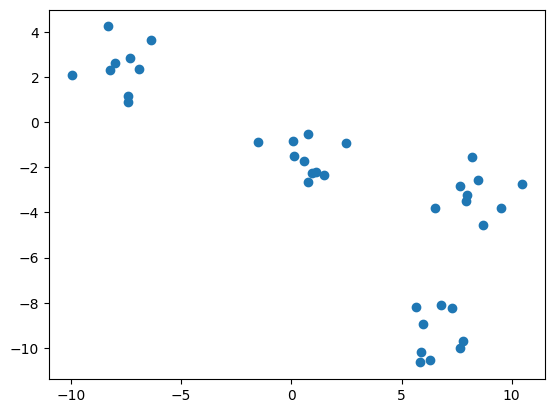

In [2]:
from sklearn.datasets import make_blobs
X, cluster = make_blobs(n_samples=45, centers=4, n_features=2, random_state=6)

X_miss = X.copy()
X_miss[[0,1,5,6],0] = np.nan
X_miss[[40,41,43,44],1] = np.nan

plt.scatter(X_miss[:, 0], X_miss[:, 1])
plt.show()

In this exercise, we will fit data models and impute missing entries using the following implausibility functions:

- **Sum of squares implausibility function:**  
  $$
  l^1_{\theta}(x) = \lVert x - \theta \rVert_2^2
  $$

- **k-means implausibility function with $k = 4$:**  
  $$
  l^2_{\theta}(x) = \min_{j = 1, \dots, 4} \lVert x - \theta_j \rVert_2^2
  $$

The implausibility functions, models, and the methods for estimating  
$\theta$ and $\theta_j$ are described in the [unsupervised learning slides](https://vzdelavanie.uniza.sk/moodle/pluginfile.php/290779/mod_resource/content/1/13.%20Unsupervised_learning.pdf),  
pages 19–29.  
To see how to perform k-means clustering, refer to the [`sklearn.cluster.KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) documentation.

We begin by minimizing $l^1_{\theta}$ over $\theta$. You can find the estimator for this case in the slides.

To compute the mean of an array containing missing values, use `np.nanmean` with `axis=0` to obtain column-wise means.

**Your first task:**  
Estimate $\theta$ for both columns of the `X_miss` matrix.


In [6]:
theta = np.nanmean(X_miss, axis=0)
print(f"\u03b8 values: {theta}")

θ values: [ 1.95329884 -2.93627646]


Next, we identify the missing values and use the `any` method to determine which rows contain at least one `True` value (i.e., which rows include missing entries).

In [7]:
missing_i = np.isnan(X_miss).any(axis=1)
X_miss[missing_i]

array([[         nan,  -2.12266605],
       [         nan,   1.30558157],
       [         nan,  -2.6476988 ],
       [         nan, -10.00047495],
       [  8.98426675,          nan],
       [ -7.40278343,          nan],
       [  6.5390239 ,          nan],
       [  0.54911019,          nan]])

To keep the original dataset unchanged, we create a copy of it.

In [8]:
X_miss_imp = X_miss.copy()

We use the vector of missing indices to impute the values in the first column with the corresponding component of $\theta$.

In [9]:

X_miss_imp[ np.isnan(X_miss_imp)[:,0],0] = theta[0]

Now it is your turn to impute the missing values in the second column using the corresponding component of $\theta$.

In [12]:
X_miss_imp[ np.isnan(X_miss_imp)[:,1],1] = theta[1]

To visualize the imputations we performed, we plot the complete observations in blue and the imputed values in red.  
The `~` operator is used to negate the boolean vector `missing_i`, allowing us to separate missing and non-missing rows.


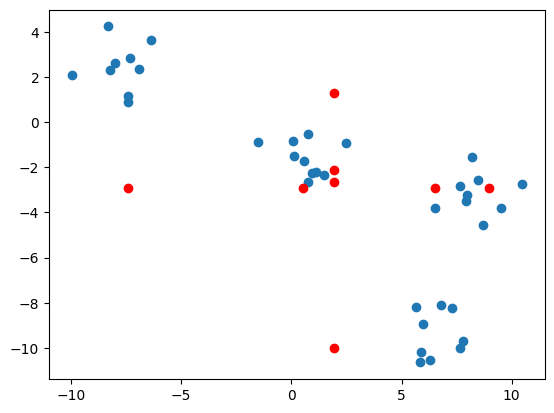

In [13]:
plt.scatter(X_miss_imp[~missing_i, 0], X_miss_imp[~missing_i, 1])
plt.scatter(X_miss_imp[missing_i, 0], X_miss_imp[missing_i, 1], color='red')
plt.show()

### More Advanced Imputations

As you can see, some of the imputed observations lie outside the natural clusters of points.  
Can we do better? Of course!

To obtain a more advanced imputation, we will use averages of groups of observations.  
We will determine $\theta_j$ (for $j = 1, \dots, 4$) for the implausibility function $l^2_{\theta}$ by applying k-means clustering to the rows of `X_miss` **that do not contain missing values**.  
Please refer to the slides for details on how the $\theta_j$ values are obtained.

**Steps:**

1. Import the appropriate model from `sklearn`.  
2. Initialize the correct unsupervised model (k-means with $k = 4$).  
3. Fit the model to the non-missing observations.  
4. Extract the $\theta_j$ estimates (the cluster centers) from the fitted model.


In [14]:
# import the appropriate model from sklearn
from sklearn.cluster import KMeans
# initialize the model with 4 thetas
model = KMeans(n_clusters=4, n_init='auto')
# fit the model to the data
model.fit(X_miss[~missing_i, :])
# extract the theta parameters
thetas_4 = model.cluster_centers_
print(f"Centers:\n{thetas_4}")

Centers:
[[ 6.56892177 -9.39440238]
 [-7.77129616  2.45571705]
 [ 8.38320667 -3.1755891 ]
 [ 0.67881443 -1.5893607 ]]


In the next step, we visualize the complete observations together with the $\theta$ values, which correspond to the cluster centers.

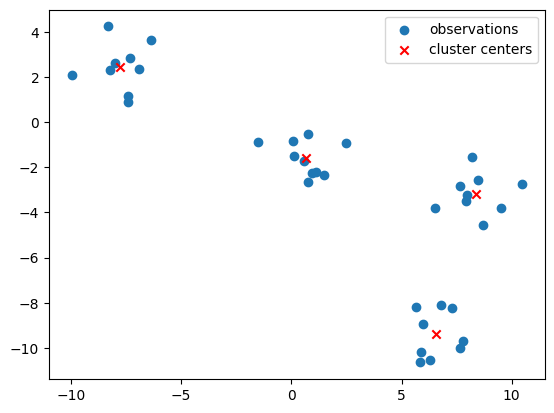

In [15]:
plt.scatter(X_miss[~missing_i, 0], X_miss[~missing_i, 1], label="observations")
plt.scatter(thetas_4[:, 0], thetas_4[:, 1], marker='x', color='red', label="cluster centers")
plt.legend()
plt.show()

Next, we loop through observations containing missing values and replace the values with the coordinate of the closest point.
Code for one dimension is provided, for the second dimension you need to do the same process.

In [20]:
# copy the data
X_miss_imp_cl4 = X_miss.copy()

for i in np.where(missing_i)[0]:
  if np.isnan(X_miss[i, 0]):
    # sets the value to the closest point
    X_miss_imp_cl4[i, 0] = thetas_4[ np.argmin( np.abs(X_miss[i, 1] - thetas_4[:,1])), 0]
  elif np.isnan(X_miss[i, 1]):
    # sets the value to the closest point
    X_miss_imp_cl4[i, 1] = thetas_4[ np.argmin( np.abs(X_miss[i, 0] - thetas_4[:,0])), 1]

To analyze the results, we plot the non-missing and imputed values.  
Please check whether all imputed points lie within their corresponding clusters. If not, it is likely that an error occurred in the imputation process.


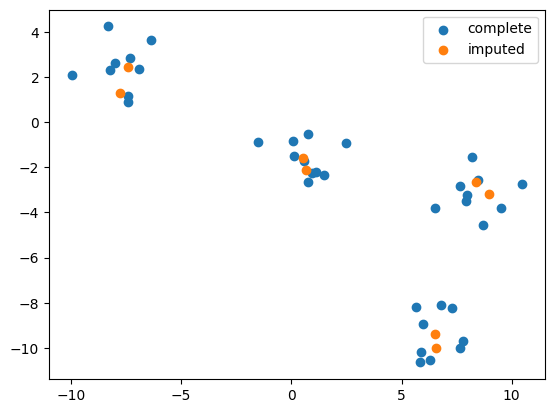

In [21]:
plt.scatter(X_miss_imp_cl4[~missing_i, 0], X_miss_imp_cl4[~missing_i, 1], label="complete")
plt.scatter(X_miss_imp_cl4[missing_i, 0], X_miss_imp_cl4[missing_i, 1], label="imputed")
plt.legend()
plt.show()

Next, we compare the imputed and the true points. The points are paired using the coordinate that was not missing, which is identical for each pair.

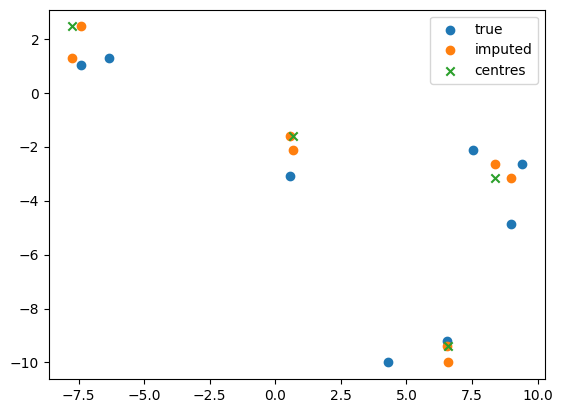

In [22]:
plt.scatter(X[missing_i, 0], X[missing_i, 1], marker="o", label="true")
plt.scatter(X_miss_imp_cl4[missing_i, 0], X_miss_imp_cl4[missing_i, 1], label="imputed")
plt.scatter(thetas_4[:, 0], thetas_4[:,1], marker="x", label="centres")
plt.legend()
plt.show()

To measure the error of the imputation, compute the RMSE.
To obtain the indices of the missing values, use `np.isnan` together with `X_miss`. The resulting RMSE should be approximately $2.7887$.

In [23]:
from sklearn.metrics import root_mean_squared_error
missing_indices = np.isnan(X_miss)
RMSE = root_mean_squared_error(X_miss_imp_cl4[missing_indices], X[missing_indices])
print(f"RMSE: {RMSE:.4f}")

RMSE: 2.7887


#### An additional info about clustering
In the previous step, we assigned the clusters using the k-means algorithm.
Cluster assignments are in the `labels_` attribute. The cluster centers are in the `cluster_centers_` attribute. A performance measure of clustering - sum of squared distances of samples to their closest cluster center, also known as SSE, can be found in attribute `inertia_`. To see the result of the clustering which centres we were using, we can display the data coloured by the cluster labels.

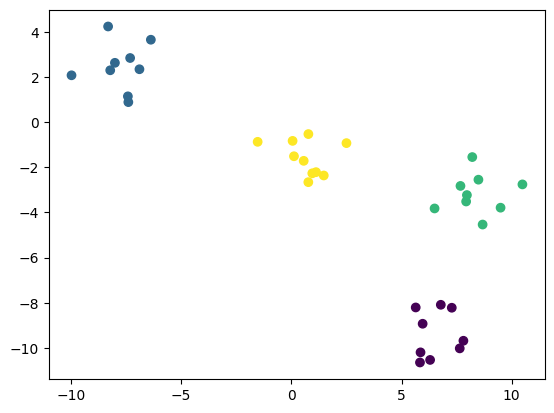

In [24]:
plt.scatter(X_miss_imp[~missing_i, 0], X_miss_imp[~missing_i, 1], c = model.labels_)
plt.show()